## 1 - Import


In [1]:
import base64
import utils
import imageio
import IPython
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from random import randint
from itertools import zip_longest
from collections import deque, namedtuple

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
from statsmodels.iolib.table import SimpleTable



## 2 - Hyperparameters
Run the cell below to set the hyperparameters.

In [6]:
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate  
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

## 3 - Coinworld Evironment
The goal of Coinworld evironment is to earn profit and maintain it from foreign exchange. Agent is only allow to trade and hold 1 currency at a time.
It has some weakness:  

Simulator
- Order/action is assumed that is immediately matched right after being made.
- Buy/sell price is the lasted matched price.
- Trading in a limit period of time.

Real-life
- The order is wait to be matched
- Outdated should be terminated
- The huy/sell should be higher/lower than the market price
- Trading non-stop

How does it work:
- Coinworld is initialized with a time series
- Perform an act each time
- At the end of the series, can not progress any further

Map:

    class Coinworld:
        def __init__:
            # Define very first variables
        
        def reset:
            # Return to the initial state

        def update_state:
            # Update the state right after sending order

        def buy:
            # Sending buy order A_t at the S_t 

        def sell:
            # Sending buy order A_t at the S_t 

        def get_reward:
            # Calculate the reward right after conduct the act A_t

In [15]:
class Coinworld:
    """
    To create
    """


    def __init__(self, series):
        """
        State = (
            Holding state, # 0 - No/Default, 1-Yes 
            History cost,  
            Current price,
            Other indicators,
                )
        """
        hold_num = randint(0, 1)
        hold_price = self.series[0, 0] if hold_num == 1 else 0 # if hold_num == 1 else None

        self.series = series
        self.size = series.shape
        self.time_stamp = 0

        self.acc_state = (hold_num, hold_price) # (hold_state, hold_price)
        self.prev_acc_state = (hold_num, hold_price)

        self.market_state = tuple(series[0])

        self.state      = self.acc_state + tuple(series[0]) # initial state is the head of the series, holding no orders
        self.prev_state = self.acc_state + tuple(series[0])

        self.goal       = tuple(series[-1]) # The goal is the end of the series, holding no orders
        if len(series) > 1:
            self.done   = False
        elif len(series) == 1:
            self.done = True
        else:
            print('Please recheck the input series')

    def reset(self, series=None):
        """
        THIS SHOULD RESET THE SEQUENCE AND RETURN THE INITIAL STATE !!

        """
        
        self.time_stamp = 0
        hold_num = random.randint(0, 1)
        hold_price = self.series[0, 0] if hold_num == 1 else 0
        self.acc_state = (hold_num, hold_price) # (hold_state, hold_price)
        self.prev_acc_state = (hold_num, hold_price)

        self.market_state = tuple(self.series[0])

        self.state      = self.acc_state + tuple(self.series[0]) # initial state is the head of the series, holding no orders
        self.prev_state = self.acc_state + tuple(self.series[0])
        return self.state

    def update_state(self):
        """
        Note:
        - timestamp should be updated according to real-time
        - Market state
        """
        self.time_stamp += 1 # Auto add up 1 to current timestamp
        self.market_state = tuple(self.series[self.time_stamp])
        self.state = self.acc_state + self.market_state

    def Buy(self):
        hold_num, hold_price = self.acc_state
        hold_num += 1
        hold_price = self.market_state[0]
        self.acc_state = (hold_num, hold_price)

    def Sell(self):
        hold_num, hold_price = self.acc_state
        hold_num -= 1
        hold_price = 0
        self.acc_state = (hold_num, hold_price)

    def get_reward(self):
        if self.prev_acc_state[0] == 1: # Reward only available when you are holding 
            previous = self.prev_acc_state[1]
            current = self.market_state[0]
            reward = current - previous
            # diff = current - previous 
            # reward =  diff/max(previous, current)        *previous # can be remove
        else:
            reward = 0
        
        return reward

    def step(self, action):
        """
        Action is a tuple (Buy, Sell, Do Nothing)
        or:
            (1,0,0) - Buy
            (0,1,0) - Sell
            (0,0,1) - Do nothing
        """
        # To check if it is terminated
        hold_state, hold_cost, *market_state = self.state

        # State from previous timestamp is saved as prev_state 
        self.prev_state = self.state

        if self.done == False:

            # Buy - when hold nothing
            if action == 1 and hold_state == 0: 
                self.Buy()

            # Sell - when have something to sell
            elif action == 2 and hold_state == 1: 
                self.Sell()

            # Do nothing - maintain the current hold state
            else:
                pass

            # Update state
            self.update_state()

            reward = self.get_reward()

            if self.market_state == self.goal:
                # reward = 0
                self.done = True


            self.prev_acc_state = self.acc_state

            print(f'Step {self.time_stamp}: reward: {reward}')
            print(f'        State: {self.prev_state}')
            print(f'        State: {self.state} ')
            return np.array(self.state), reward, self.done

        else:
            print('No more steps can be taken')

    
    def get_state_space_size(self):
        return np.array(self.state).shape

    def get_action_space_size(self):
        return 3



In [8]:
input = pd.read_pickle(r'C:\Users\Dell\OneDrive\Documents\projects\trading_bot_v0\Processed_Dataset_from_1Jan22_17Feb24.pkl') # Importing dataset from pickle
series = np.array(input[['close']][:]) # Choosing last 1000 data points in close column



In [9]:
env = Coinworld(series[-10000:])
env.reset()
# print(evn.acc_state)
print(f'Initial state: {env.state}')
action = (1,0,0)
for i in range(11):
    env.step(action)

AttributeError: 'Coinworld' object has no attribute 'series'

<a name="6"></a>
## 6 - Deep Q-Learning

In cases where both the state and action space are discrete we can estimate the action-value function iteratively by using the Bellman equation:

$$
Q_{i+1}(s,a) = R + \gamma \max_{a'}Q_i(s',a')
$$

This iterative method converges to the optimal action-value function $Q^*(s,a)$ as $i\to\infty$. This means that the agent just needs to gradually explore the state-action space and keep updating the estimate of $Q(s,a)$ until it converges to the optimal action-value function $Q^*(s,a)$. However, in cases where the state space is continuous it becomes practically impossible to explore the entire state-action space. Consequently, this also makes it practically impossible to gradually estimate $Q(s,a)$ until it converges to $Q^*(s,a)$.

In the Deep $Q$-Learning, we solve this problem by using a neural network to estimate the action-value function $Q(s,a)\approx Q^*(s,a)$. We call this neural network a $Q$-Network and it can be trained by adjusting its weights at each iteration to minimize the mean-squared error in the Bellman equation.

Unfortunately, using neural networks in reinforcement learning to estimate action-value functions has proven to be highly unstable. Luckily, there's a couple of techniques that can be employed to avoid instabilities. These techniques consist of using a ***Target Network*** and ***Experience Replay***. We will explore these two techniques in the following sections.

In [ ]:
state_size = env.get_state_space_size()
num_actions = env.get_action_space_size()

# Create the Q-Network
q_network = Sequential([
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear'),
    ])

# Create the target Q^-Network
target_q_network = Sequential([
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear'),
    ])

optimizer = Adam(learning_rate=ALPHA)


In [ ]:
# Store experiences as named tuples
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [ ]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    """ 
    Calculates the loss.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Karas model for predicting the targets
          
    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """
    
    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences
    
    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    
    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    ### START CODE HERE ### 
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))
    ### END CODE HERE ###
    
    # Get the q_values
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))
        
    # Compute the loss
    ### START CODE HERE ### 
    loss = MSE(y_targets, q_values) 
    ### END CODE HERE ### 
    
    return loss

In [ ]:
@tf.function
def agent_learn(experiences, gamma):
    """
    Updates the weights of the Q networks.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
    
    """
    
    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)
    
    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network
    utils.update_target_network(q_network, target_q_network)

<a name="9"></a>
## 9 - Train the Agent

We are now ready to train our agent to solve the Lunar Lander environment. In the cell below we will implement the algorithm in [Fig 3](#7) line by line (please note that we have included the same algorithm below for easy reference. This will prevent you from scrolling up and down the notebook):

* **Line 1**: We initialize the `memory_buffer` with a capacity of $N =$ `MEMORY_SIZE`. Notice that we are using a `deque` as the data structure for our `memory_buffer`.


* **Line 2**: We skip this line since we already initialized the `q_network` in [Exercise 1](#ex01).


* **Line 3**: We initialize the `target_q_network` by setting its weights to be equal to those of the `q_network`.


* **Line 4**: We start the outer loop. Notice that we have set $M =$ `num_episodes = 2000`. This number is reasonable because the agent should be able to solve the Lunar Lander environment in less than `2000` episodes using this notebook's default parameters.


* **Line 5**: We use the `.reset()` method to reset the environment to the initial state and get the initial state.


* **Line 6**: We start the inner loop. Notice that we have set $T =$ `max_num_timesteps = 1000`. This means that the episode will automatically terminate if the episode hasn't terminated after `1000` time steps.


* **Line 7**: The agent observes the current `state` and chooses an `action` using an $\epsilon$-greedy policy. Our agent starts out using a value of $\epsilon =$ `epsilon = 1` which yields an $\epsilon$-greedy policy that is equivalent to the equiprobable random policy. This means that at the beginning of our training, the agent is just going to take random actions regardless of the observed `state`. As training progresses we will decrease the value of $\epsilon$ slowly towards a minimum value using a given $\epsilon$-decay rate. We want this minimum value to be close to zero because a value of $\epsilon = 0$ will yield an $\epsilon$-greedy policy that is equivalent to the greedy policy. This means that towards the end of training, the agent will lean towards selecting the `action` that it believes (based on its past experiences) will maximize $Q(s,a)$. We will set the minimum $\epsilon$ value to be `0.01` and not exactly 0 because we always want to keep a little bit of exploration during training. If you want to know how this is implemented in code we encourage you to take a look at the `utils.get_action` function in the `utils` module.


* **Line 8**: We use the `.step()` method to take the given `action` in the environment and get the `reward` and the `next_state`. 


* **Line 9**: We store the `experience(state, action, reward, next_state, done)` tuple in our `memory_buffer`. Notice that we also store the `done` variable so that we can keep track of when an episode terminates. This allowed us to set the $y$ targets in [Exercise 2](#ex02).


* **Line 10**: We check if the conditions are met to perform a learning update. We do this by using our custom `utils.check_update_conditions` function. This function checks if $C =$ `NUM_STEPS_FOR_UPDATE = 4` time steps have occured and if our `memory_buffer` has enough experience tuples to fill a mini-batch. For example, if the mini-batch size is `64`, then our `memory_buffer` should have at least `64` experience tuples in order to pass the latter condition. If the conditions are met, then the `utils.check_update_conditions` function will return a value of `True`, otherwise it will return a value of `False`.


* **Lines 11 - 14**: If the `update` variable is `True` then we perform a learning update. The learning update consists of sampling a random mini-batch of experience tuples from our `memory_buffer`, setting the $y$ targets, performing gradient descent, and updating the weights of the networks. We will use the `agent_learn` function we defined in [Section 8](#8) to perform the latter 3.


* **Line 15**: At the end of each iteration of the inner loop we set `next_state` as our new `state` so that the loop can start again from this new state. In addition, we check if the episode has reached a terminal state (i.e we check if `done = True`). If a terminal state has been reached, then we break out of the inner loop.


* **Line 16**: At the end of each iteration of the outer loop we update the value of $\epsilon$, and check if the environment has been solved. We consider that the environment has been solved if the agent receives an average of `200` points in the last `100` episodes. If the environment has not been solved we continue the outer loop and start a new episode.

Finally, we wanted to note that we have included some extra variables to keep track of the total number of points the agent received in each episode. This will help us determine if the agent has solved the environment and it will also allow us to see how our agent performed during training. We also use the `time` module to measure how long the training takes. 


**Note:** With this notebook's default parameters, the following cell takes between 10 to 15 minutes to run. 

In [ ]:
start = time.time()

num_episodes = 2000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):
    
    # Reset the environment to the initial state and get the initial state
    state = env.reset()
    total_points = 0
    
    for t in range(max_num_timesteps):
        
        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
        try:
            q_values = q_network(state_qn)
        except Exception as e:
            print(e, state_qn)

        action = utils.get_action(q_values, epsilon)
        
        # Take action A and receive reward R and the next state S'
        # next_state, reward, done, _ = env.step(action)
        next_state, reward, done = env.step(action)
        
        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))
        
        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        
        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = utils.get_experiences(memory_buffer)
            
            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            agent_learn(experiences, GAMMA)
        
        state = next_state.copy()
        total_points += reward
        
        if done:
            break
            
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    
    # Update the ε value
    epsilon = utils.get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 2000.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('trading_model.h5')
        break
        
tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

In [ ]:
# Plot the point history
utils.plot_history(total_point_history)

## Deployment

In [16]:
model = tf.keras.models.load_model('trading_model.h5')

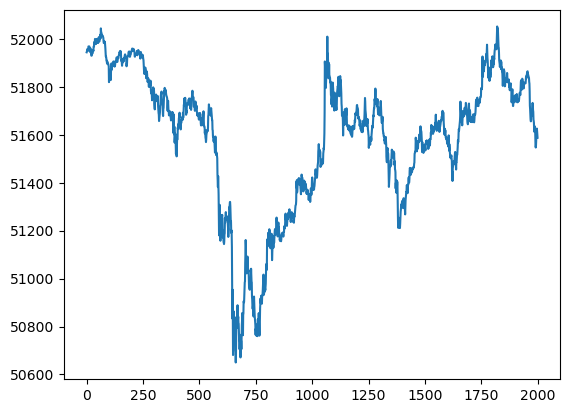

In [17]:
plt.plot(series[-2000:])


In [18]:
input = pd.read_pickle(r'C:\Users\Dell\OneDrive\Documents\projects\trading_bot_v0\Processed_Dataset_from_1Jan22_17Feb24.pkl') # Importing dataset from pickle
series = np.array(input[['close']][:]) # Choosing last 1000 data points in close column
env_1 = Coinworld(series[-2000:])

In [19]:
total_reward = 0
state = env_1.reset()
for i in range(1500):
    q_values =  model(np.expand_dims(state, axis=0))
    action = np.argmax(q_values.numpy()[0])
    print(action)
    state, reward, done = env_1.step(action)
    total_reward += reward 
print(total_reward)


1
Step 1: reward: 0
        State: (0, 0, 51944.16)
        State: (1, 51944.16, 51946.89) 
1
Step 2: reward: 7.26953125
        State: (1, 51944.16, 51946.89)
        State: (1, 51944.16, 51951.43) 
1
Step 3: reward: 13.3984375
        State: (1, 51944.16, 51951.43)
        State: (1, 51944.16, 51957.56) 
1
Step 4: reward: 13.41015625
        State: (1, 51944.16, 51957.56)
        State: (1, 51944.16, 51957.57) 
1
Step 5: reward: 13.41015625
        State: (1, 51944.16, 51957.57)
        State: (1, 51944.16, 51957.57) 
1
Step 6: reward: 5.8515625
        State: (1, 51944.16, 51957.57)
        State: (1, 51944.16, 51950.01) 
1
Step 7: reward: 16.9296875
        State: (1, 51944.16, 51950.01)
        State: (1, 51944.16, 51961.09) 
1
Step 8: reward: 24.58984375
        State: (1, 51944.16, 51961.09)
        State: (1, 51944.16, 51968.75) 
1
Step 9: reward: 24.6015625
        State: (1, 51944.16, 51968.75)
        State: (1, 51944.16, 51968.76) 
1
Step 10: reward: 24.58984375
        Sta

In [26]:
total_reward = 0
state = env_1.reset()
for i in range(100):
    q_values =  model(np.expand_dims(state, axis=0))
    action = random.randint(1,3)
    print(action)
    state, reward, done = env_1.step(action)
    total_reward += reward 
print(total_reward)

3
No more steps can be taken


TypeError: cannot unpack non-iterable NoneType object